In [192]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller

In [80]:
sns.set_theme('paper')
sns.set_style('ticks')

In [224]:
q = 1
delta = 7
omega = 28
experiment = f"run_ETE_w{omega}_d{delta}_S_Q1_-{q}_Q2_{q}_risk_ij"
exp_folder = f"../outputs/TE_cnig_provincias/{experiment}/"

base_folder = "../outputs/TE_cnig_provincias/"
cases_fname = os.path.join(base_folder, "cases_pop_ds.nc")
risk_ij_fname = os.path.join(base_folder, "risk_ds.nc")

cases_ds = xr.load_dataset(cases_fname)
risk_ds = xr.load_dataset(risk_ij_fname)

trips_ij_da = risk_ds['trips_ij']
dt_trips_ij_da = trips_ij_da.diff('date')

risk_ij_da = risk_ds['risk_ij']
dt_risk_ij_da = risk_ij_da.diff('date')

cases_by_100k_da = cases_ds['new_cases_by_100k']
dt_cases_by_100k_da = cases_by_100k_da.diff('date')

dates = risk_ij_dt.coords['date'][:300]
provinces = cases_by_100k_dt.coords['id'].values

results_fname = os.path.join(exp_folder, "TE.nc")
TE_ds = xr.load_dataset(results_fname)
TE  = TE_ds['TE_dynamic']
ETE = TE_ds['ETE_dynamic']

X_fname = os.path.join(exp_folder, "X.nc")
X_ij = xr.load_dataarray(X_fname)

Y_fname = os.path.join(exp_folder, "Y.nc")
Y_j = xr.load_dataarray(Y_fname)

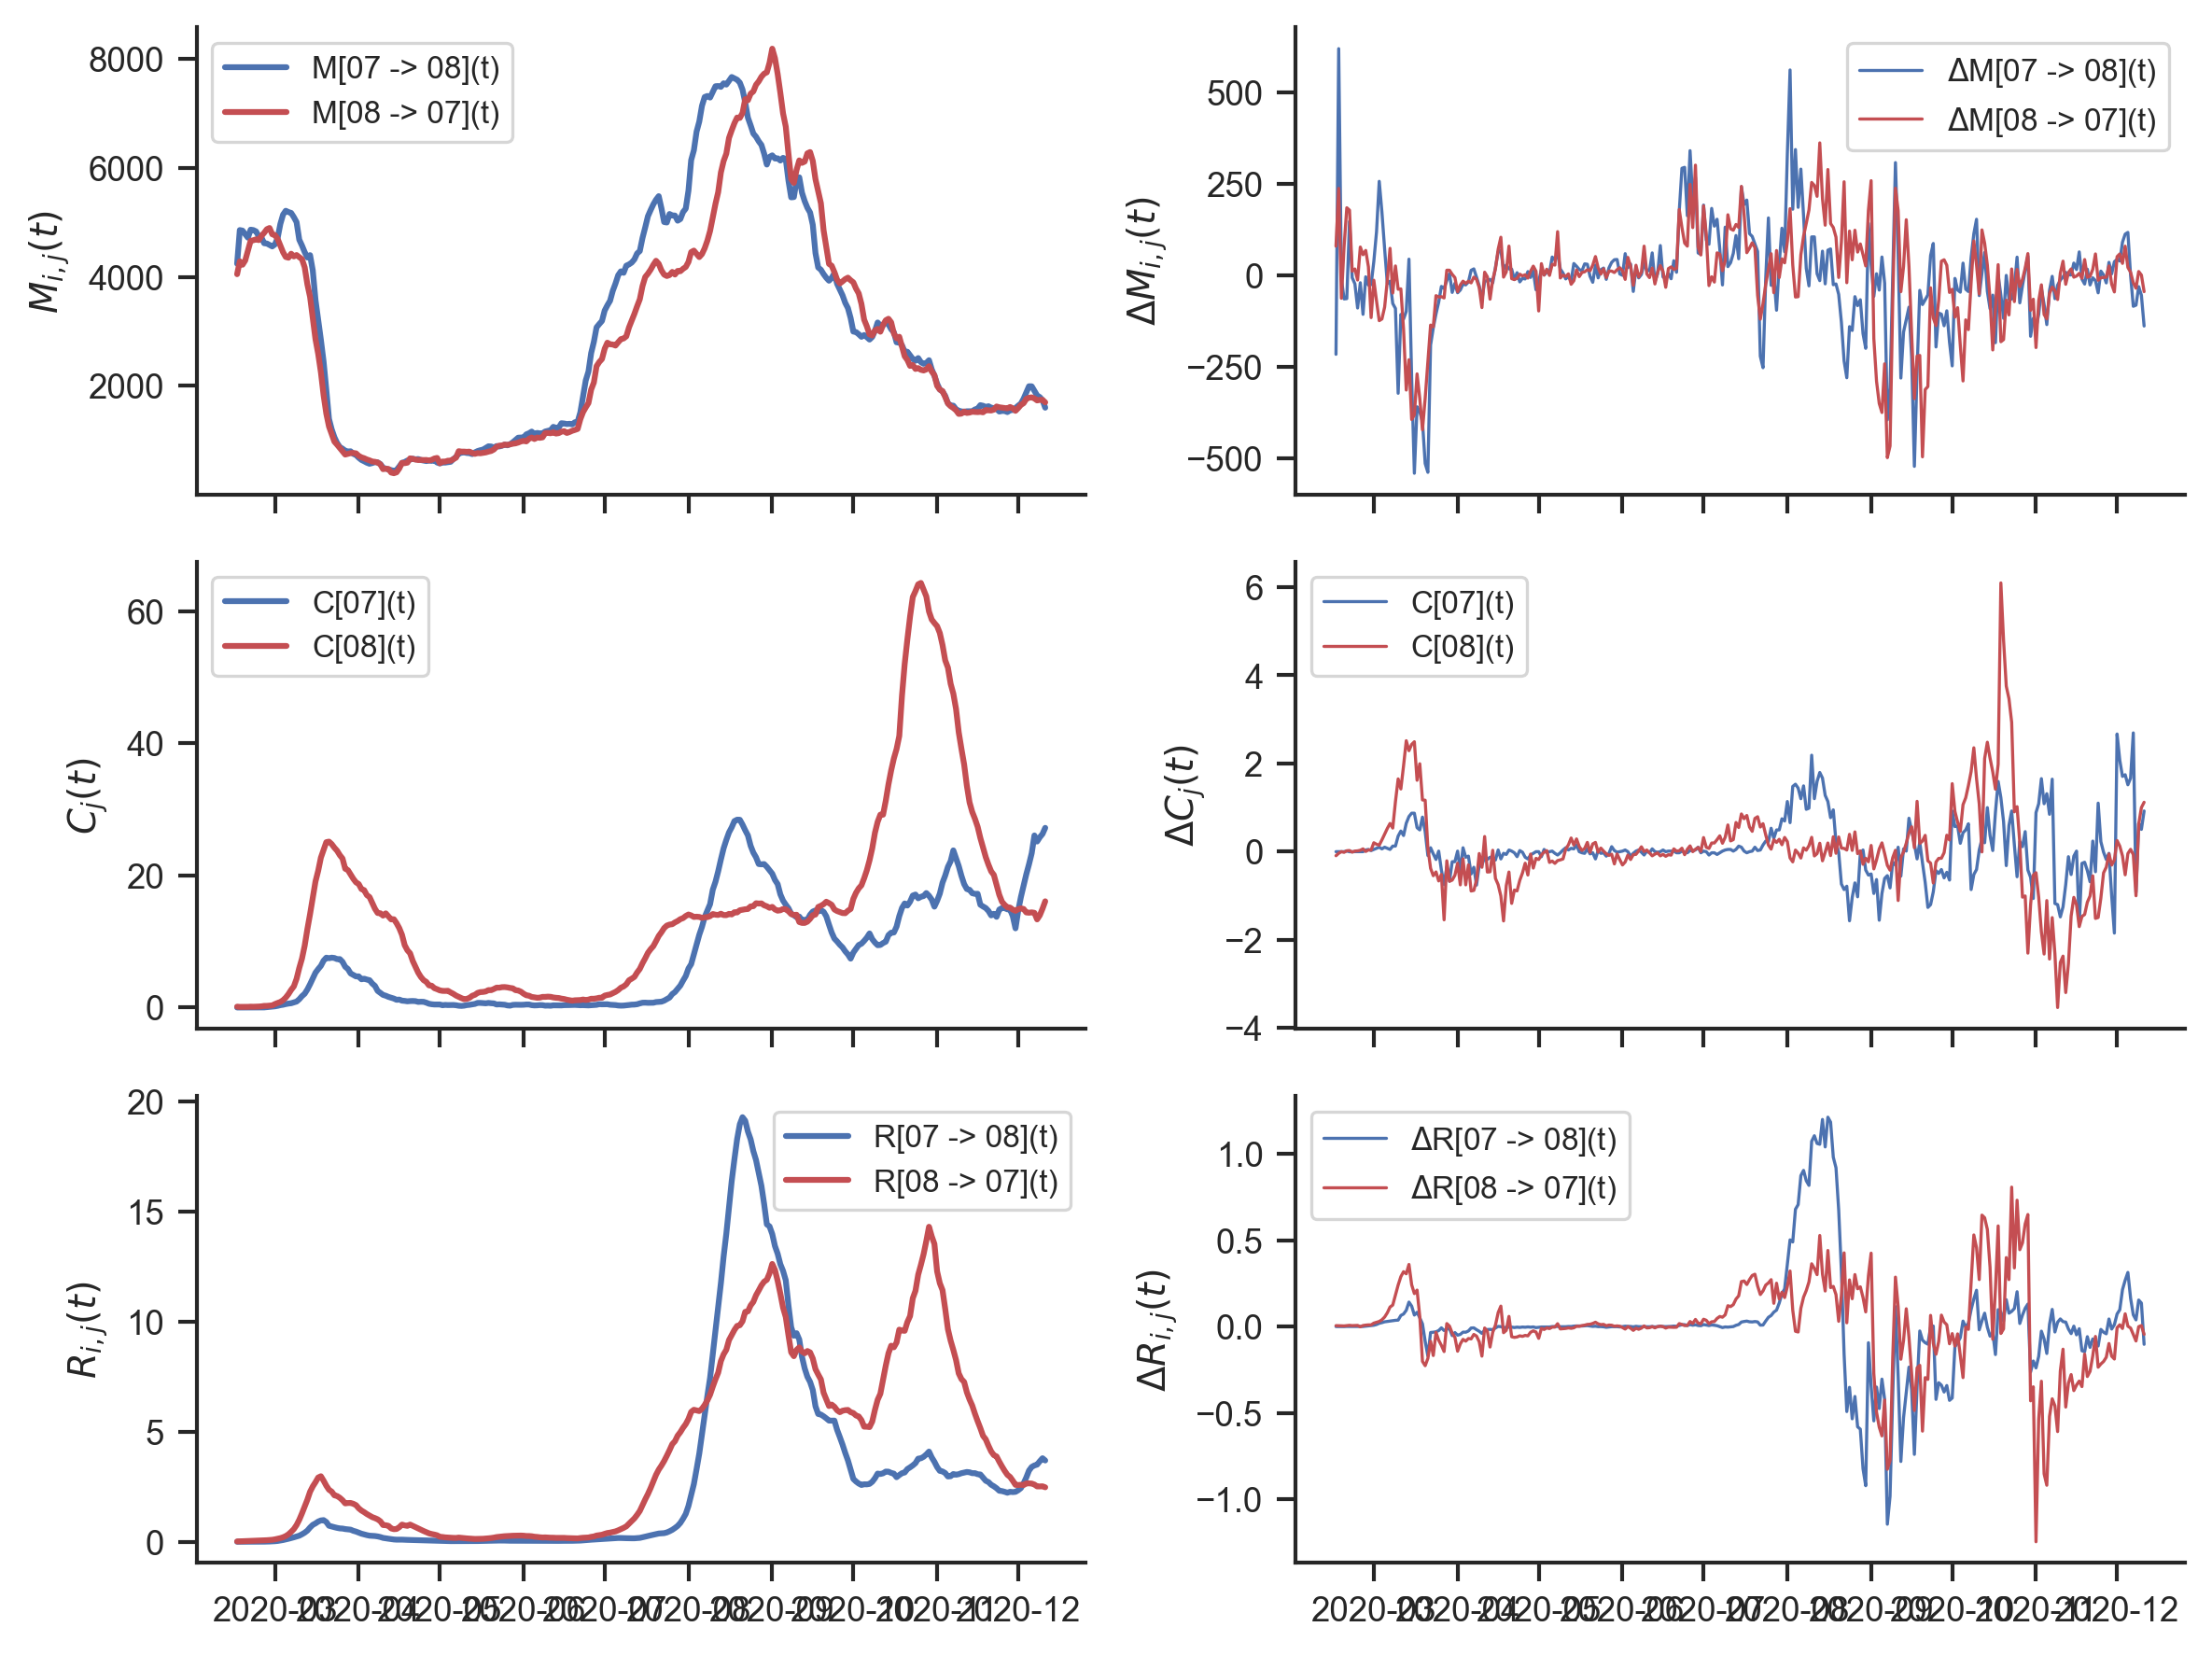

In [213]:
i = "07"
j = "08"


trips_ij_df = trips_ij_da.loc[i, j, dates].to_pandas()
trips_ji_df = trips_ij_da.loc[j, i, dates].to_pandas()

dt_trips_ij_df = dt_trips_ij_da.loc[i, j, dates].to_pandas()
dt_trips_ji_df = dt_trips_ij_da.loc[j, i, dates].to_pandas()


risk_ij_df = risk_ij_da.loc[i, j, dates].to_pandas()
risk_ji_df = risk_ij_da.loc[j, i, dates].to_pandas()

dt_risk_ij_df = dt_risk_ij_da.loc[i, j, dates].to_pandas()
dt_risk_ji_df = dt_risk_ij_da.loc[j, i, dates].to_pandas()


cases_i_df = cases_by_100k_da.loc[i, dates].to_pandas()
cases_j_df = cases_by_100k_da.loc[j, dates].to_pandas()

dt_cases_i_df = dt_cases_by_100k_da.loc[i, dates].to_pandas()
dt_cases_j_df = dt_cases_by_100k_da.loc[j, dates].to_pandas()


lw = 1.5
lw_dt = 0.8
fig, axes = plt.subplots(3, 2, figsize=(8,6), sharex=True, dpi=300)

ax = axes[0,0]
ax.plot(trips_ij_df, label=rf"M[{i} -> {j}](t)", lw=lw)
ax.plot(trips_ji_df, label=rf"M[{j} -> {i}](t)", c='r', lw=lw)
ax.legend(loc=0, ncol=1, fancybox=True, fontsize="8")
ax.set_ylabel(r"$M_{i,j}(t)$")

ax = axes[0,1]
ax.plot(dt_trips_ij_df, label=rf"$\Delta$M[{i} -> {j}](t)", lw=lw_dt)
ax.plot(dt_trips_ji_df, label=rf"$\Delta$M[{j} -> {i}](t)", c='r', lw=lw_dt)
ax.legend(loc=0, ncol=1, fancybox=True, fontsize="8")
ax.set_ylabel(r"$\Delta M_{i,j}(t)$")


ax = axes[1,0]
ax.plot(cases_i_df, label=rf"C[{i}](t)", lw=lw)
ax.plot(cases_j_df, label=rf"C[{j}](t)", lw=lw, c='r')
ax.legend(loc=0, ncol=1, fancybox=True, fontsize="8")
ax.set_ylabel(r"$C_{j}(t)$")

ax = axes[1,1]
ax.plot(dt_cases_i_df, label=rf"C[{i}](t)", lw=lw_dt)
ax.plot(dt_cases_j_df, label=rf"C[{j}](t)", lw=lw_dt, c='r')
ax.legend(loc=0, ncol=1, fancybox=True, fontsize="8")
ax.set_ylabel(r"$\Delta C_{j}(t)$")


ax = axes[2,0]
ax.plot(risk_ij_df, label=rf"R[{i} -> {j}](t)", lw=lw)
ax.plot(risk_ji_df, label=rf"R[{j} -> {i}](t)", c='r', lw=lw)
ax.legend(loc=0, ncol=1, fancybox=True, fontsize="8")
ax.set_ylabel(r"$R_{i,j}(t)$")

ax = axes[2,1]
ax.plot(dt_risk_ij_df, label=rf"$\Delta$R[{i} -> {j}](t)", lw=lw_dt)
ax.plot(dt_risk_ji_df, label=rf"$\Delta$R[{j} -> {i}](t)", c='r', lw=lw_dt)
ax.legend(loc=0, ncol=1, fancybox=True, fontsize="8")
ax.set_ylabel(r"$\Delta R_{i,j}(t)$")

sns.despine()
fig.tight_layout()

date
2020-02-16    1
2020-02-17    1
2020-02-18    1
2020-02-19    1
2020-02-20    1
             ..
2021-05-04    0
2021-05-05    1
2021-05-06    0
2021-05-07    1
2021-05-08    1
Length: 448, dtype: int32

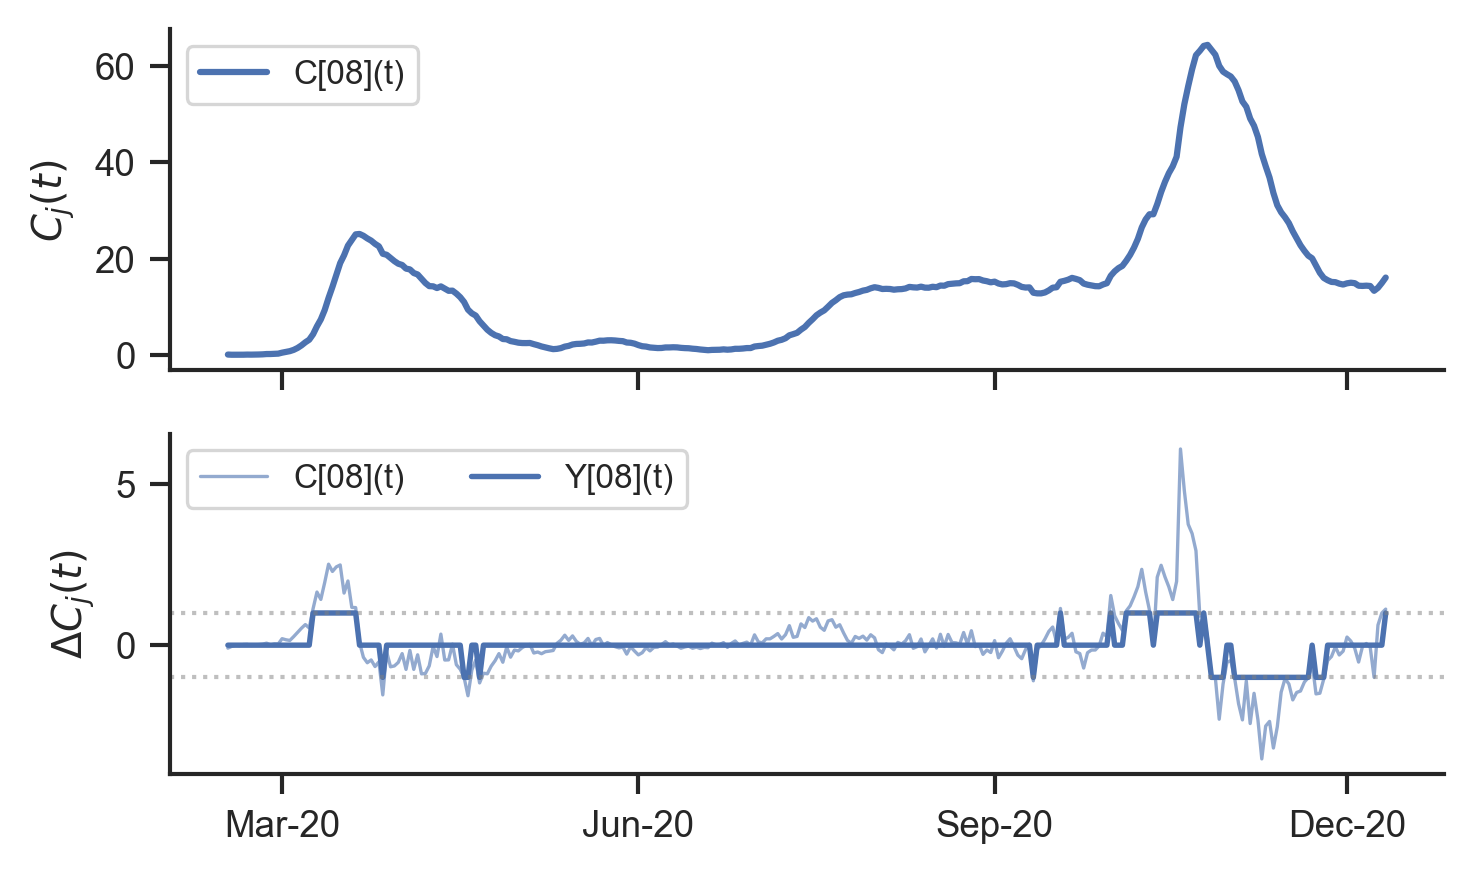

In [260]:
lw = 1.5
lw_dt = 0.8
fig, axes = plt.subplots(2, 1, figsize=(5, 3), sharex=True, dpi=300)

ax = axes[0]
ax.plot(cases_j_df, label=rf"C[{j}](t)", lw=lw, c='b')
ax.legend(loc=0, ncol=1, fancybox=True, fontsize="8")
ax.set_ylabel(r"$C_{j}(t)$")

ax = axes[1]
ax.plot(dt_cases_j_df, label=rf"C[{j}](t)", lw=lw_dt, c='b', alpha=0.6)
ax.legend(loc=0, ncol=1, fancybox=True, fontsize="8")
ax.set_ylabel(r"$\Delta C_{j}(t)$")

ax.plot(Y_j.loc[j,dates].to_pandas()-1, label=rf"Y[{j}](t)", lw=1.3, c='b')
ax.legend(loc=2, ncol=4, fancybox=True, fontsize="8")
ax.axhline(y = 1, color = 'grey', lw=1, linestyle = 'dotted', alpha=0.5) 
ax.axhline(y = -1, color = 'grey', lw=1, linestyle = 'dotted', alpha=0.5) 

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) 
sns.despine()
fig.tight_layout()

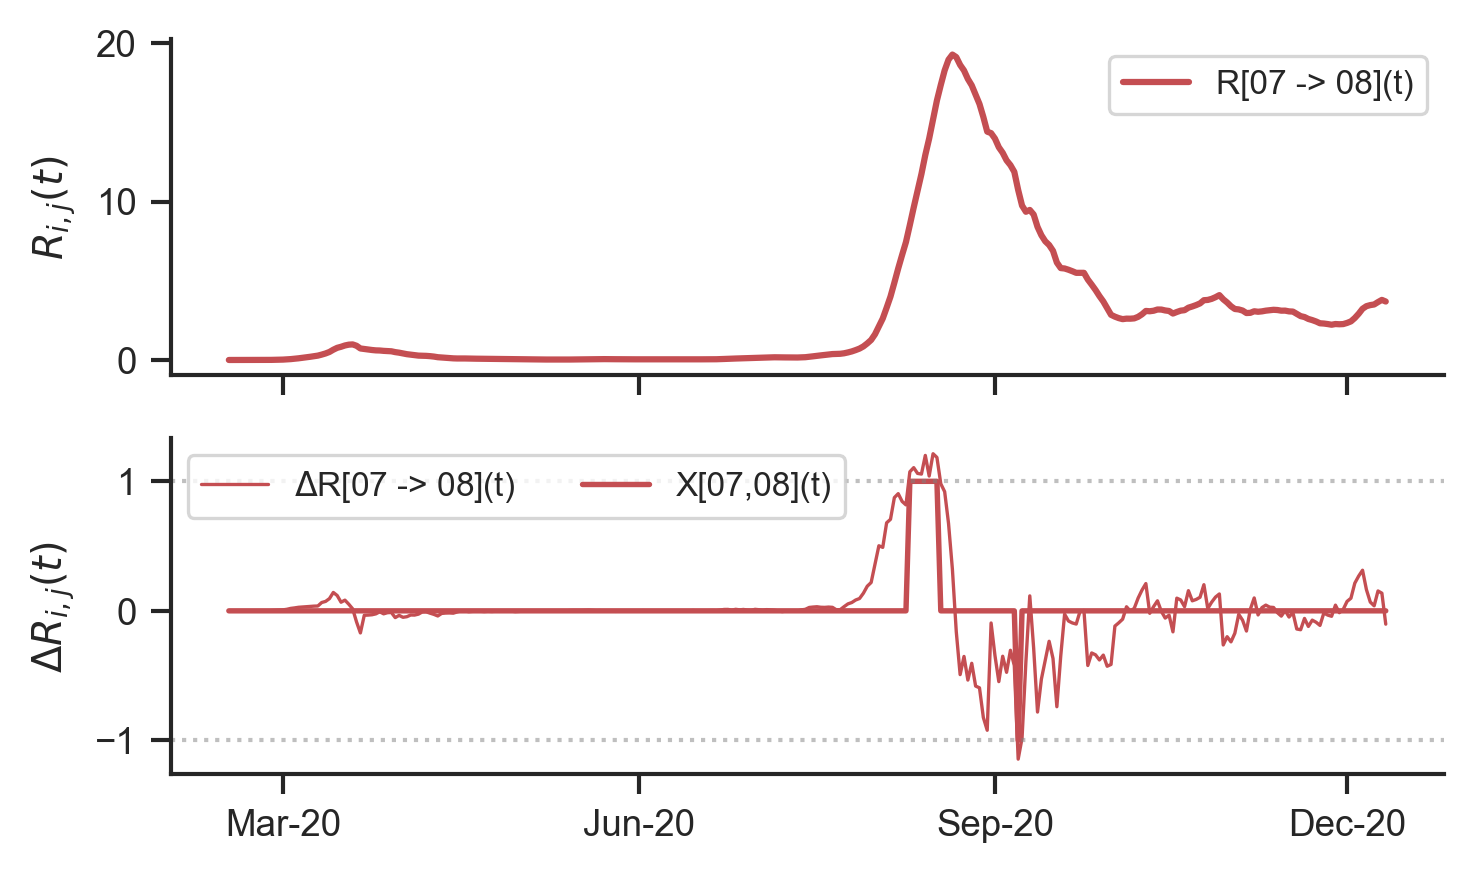

In [268]:
lw = 1.5
lw_dt = 0.8
fig, axes = plt.subplots(2, 1, figsize=(5, 3), sharex=True, dpi=300)

ax = axes[0]
ax.plot(risk_ij_df, label=rf"R[{i} -> {j}](t)", lw=lw, c='r')
ax.legend(loc=0, ncol=1, fancybox=True, fontsize="8")
ax.set_ylabel(r"$R_{i,j}(t)$")

ax = axes[1]
ax.plot(dt_risk_ij_df, label=rf"$\Delta$R[{i} -> {j}](t)", c='r', lw=lw_dt)
ax.set_ylabel(r"$\Delta R_{i,j}(t)$")


ax.plot(X_ij.loc[i, j,dates].to_pandas()-1, label=rf"X[{i},{j}](t)", lw=1.3, c='r')
ax.legend(loc=2, ncol=2, fancybox=True, fontsize="8")
ax.axhline(y = 1, color = 'grey', lw=1, linestyle = 'dotted', alpha=0.5) 
ax.axhline(y = -1, color = 'grey', lw=1, linestyle = 'dotted', alpha=0.5) 


ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) 





sns.despine()
fig.tight_layout()

## Testing for time series stationarirty

ADF is applied to each time serie $R_{i,j}(t)$ and $C_i(t)$ after applying first order differences on the time-series

Performing an augmented Dickey-Fuller test, with the following hypotheses:
* H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.
* HA: The time series is stationary.



In [6]:
Rij_adf_p_vals = []
thr = 0.05
for x in provinces:
    for y in provinces:
        if x == y:
            continue
        result = adfuller(risk_ij.loc[x,y,:].values)
        pvalue = result[1]
        result_dt = adfuller(risk_ij_dt.loc[x,y,:].values)
        pvalue_dt = result_dt[1]
        Rij_adf_p_vals.append((x, y, pvalue, pvalue_dt))


df_Rij_ADF_p_vals = pd.DataFrame(data=Rij_adf_p_vals, columns=['source', 'target', 'pval', 'pval_dt'])
df_Rij_ADF_p_vals.to_csv("../results/Supplementary_Table_ADF_test_risk_ij.csv")

In [7]:
cases_adf_p_vals = []
thr = 0.05
for x in provinces:
    result = adfuller(cases_by_100k.loc[x,:].values)
    pvalue = result[1]

    result_dt = adfuller(cases_by_100k_dt.loc[x,:].values)
    pvalue_dt = result_dt[1]
    cases_adf_p_vals.append((x, pvalue, pvalue_dt))

df_cases_ADF_p_vals = pd.DataFrame(data=cases_adf_p_vals, columns=['source', 'pval', 'pval_dt'])
df_cases_ADF_p_vals.to_csv("../results/Supplementary_Table_ADF_test_cases_j.csv")

In [16]:
eps = 0.01
print(f"Stationarity (ADF) test for cases_j(t) ts. % of significant: {(df_cases_ADF_p_vals['pval'] < eps).sum() / df_cases_ADF_p_vals.shape[0]*100}")
print(f"Stationarity (ADF) test for diff(cases_j(t)) ts. % of significant: {(df_cases_ADF_p_vals['pval_dt'] < eps).sum() / df_cases_ADF_p_vals.shape[0]*100}")

print(f"Stationarity (ADF) test for risk_ij(t) ts. % of significant: {(df_Rij_ADF_p_vals['pval'] < eps).sum() / df_Rij_ADF_p_vals.shape[0]*100}")
print(f"Stationarity (ADF) test for diff(risk_ij(t)) ts. % of significant: {(df_Rij_ADF_p_vals['pval_dt'] < eps).sum() / df_Rij_ADF_p_vals.shape[0]*100}")

Stationarity (ADF) test for cases_j(t) ts. % of significant: 4.0
Stationarity (ADF) test for diff(cases_j(t)) ts. % of significant: 100.0
Stationarity (ADF) test for risk_ij(t) ts. % of significant: 5.1020408163265305
Stationarity (ADF) test for diff(risk_ij(t)) ts. % of significant: 97.91836734693877


In [182]:
df = (np.abs(risk_ij_da) > 1).sum('date').to_dataframe()
df = df[df['risk_ij'] > 7]
data = []
data_dict = {}
for i,j in df.index:
    data_dict[(i,j)] = dt_risk_ij_da.loc[i,j,:].to_pandas()
    data.append([i,j] + np.quantile(dt_risk_ij_da.loc[i,j,:].values, [0.03, 0.97]).tolist())

pd.DataFrame(data, columns=['i', 'j' ,'q1', 'q2']).set_index(['i','j']).mean()

q1   -1.038316
q2    1.018347
dtype: float64

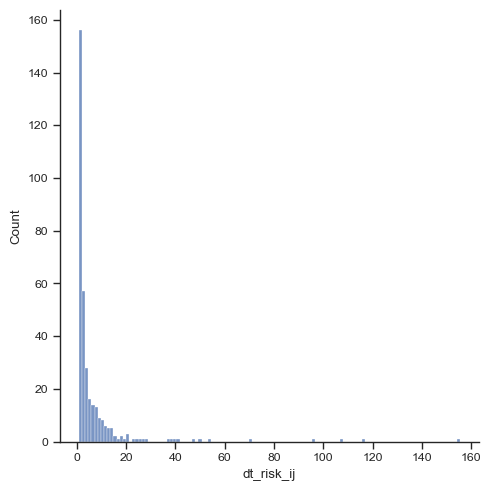

In [179]:
df = pd.concat(data_dict, names=['source', 'target', 'date'])
df = df.sort_index()
df = pd.DataFrame(df, columns=['dt_risk_ij'])
df = df.groupby(['source','target']).max('dt_risk_ij').sort_values(by='dt_risk_ij')
sns.displot(df[df['dt_risk_ij']>=0.75], x='dt_risk_ij')

In [183]:


ii = ''
for i,j in df.index:
    s = dt_risk_ij_da.loc[i,j,:].to_pandas()
    if s.max() < 1:
        continue
    if i != ii:
        ii = i;
        print()
        print("=============")
        print(i)
        print("=============")
    
    print(f"diff R[ {i} -> {j} ]:   {s.min():.3f}  <  {s.mean():.3f} ({s.std():.3f})  <  {s.max():.3f}")




01
diff R[ 01 -> 09 ]:   -3.876  <  0.056 (1.197)  <  4.249
diff R[ 01 -> 20 ]:   -5.857  <  0.035 (0.960)  <  3.416
diff R[ 01 -> 26 ]:   -4.663  <  0.058 (1.283)  <  4.380
diff R[ 01 -> 31 ]:   -1.490  <  0.021 (0.463)  <  1.711
diff R[ 01 -> 39 ]:   -1.794  <  0.004 (0.232)  <  1.364
diff R[ 01 -> 48 ]:   -11.990  <  0.106 (2.384)  <  14.906

02
diff R[ 02 -> 03 ]:   -3.193  <  0.008 (0.787)  <  5.205
diff R[ 02 -> 13 ]:   -2.266  <  0.008 (0.537)  <  3.336
diff R[ 02 -> 16 ]:   -7.706  <  0.018 (1.423)  <  10.982
diff R[ 02 -> 23 ]:   -1.320  <  0.001 (0.184)  <  1.883
diff R[ 02 -> 28 ]:   -0.979  <  0.002 (0.238)  <  1.244
diff R[ 02 -> 30 ]:   -3.326  <  0.012 (0.999)  <  6.814
diff R[ 02 -> 46 ]:   -2.602  <  0.007 (0.678)  <  4.301

03
diff R[ 03 -> 02 ]:   -6.319  <  0.004 (1.362)  <  9.724
diff R[ 03 -> 04 ]:   -1.181  <  0.001 (0.244)  <  1.709
diff R[ 03 -> 08 ]:   -0.945  <  0.001 (0.192)  <  1.348
diff R[ 03 -> 12 ]:   -1.082  <  0.001 (0.240)  <  1.528
diff R[ 03 -> 18